In [1]:
import pyfolio as pf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from datetime import date
import ast  # Import the Abstract Syntax Trees module

In [23]:
RETRAIN_DATES = [date(2021, 12, 15), date(2022, 12, 15)]
RETRAIN_DATES = [date(2018, 12, 15), date(2019, 12, 15)]
def add_retrain_dates(plt):
    for retrain_date in RETRAIN_DATES:
        plt.axvline(x=retrain_date, color='red', linestyle='--', lw=2)

    # Dynamically adjust the vertical position for annotations to avoid intersection
    # You can adjust 'adjustment_factor' to place the text appropriately
    adjustment_factor = plt.ylim()[1] * 0.99  # Adjust this factor as needed

    # Annotate the red lines, adjusting the y position
    for retrain_date in RETRAIN_DATES:
        plt.text(retrain_date, adjustment_factor, 'Model is retrained', color='red', ha='right', va='top', rotation=45)

In [24]:
# 1overN - 0.34, SPY 0.56 (anual v. 17)

In [32]:
LINEAR_OSHARPE = 'conv_full_opti'#'LSTM_1_year_without_C'
SPY = 'SPY'
EQP = 'ewp'

PERIOD = 'old'
WITH_TRANSACTIONS_COSTS = False

In [33]:
perf = pd.read_csv(fr'.\perfs\{PERIOD}\C={"0.001" if WITH_TRANSACTIONS_COSTS else "0"}\{LINEAR_OSHARPE}_perf.csv', index_col=0)
benchmark =  pd.read_csv(fr'.\perfs\{PERIOD}\{SPY}_perf.csv', index_col=0)
eqp_perf =  pd.read_csv(fr'.\perfs\{PERIOD}\{EQP}_perf.csv', index_col=0)

In [34]:
strategy_returns = perf['returns']
strategy_returns.index = pd.to_datetime(strategy_returns.index)

benchmark_returns = benchmark['returns']
benchmark_returns.index = pd.to_datetime(strategy_returns.index)

eqp_returns = eqp_perf['returns']
eqp_returns.index = pd.to_datetime(strategy_returns.index)

In [35]:
# Zipline is using parametrc for of ~ 97.5% VaR
returns = perf['returns']

# Set the confidence level
confidence_level = 0.975

# Calculate the VaR threshold
VaR_threshold = returns.quantile(1 - confidence_level)

# Calculate Expected Shortfall as the mean of the returns that are worse than the VaR threshold
ES = returns[returns <= VaR_threshold].mean()
ES

-0.030524276519332403

Start date,2017-12-15
End date,2020-12-15
Total months,35
,Backtest
Annual return,9.268%
Cumulative returns,30.415%
Annual volatility,15.021%
Sharpe ratio,0.67
Calmar ratio,0.49
Stability,0.68
Max drawdown,-18.944%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,18.94,2019-11-29,2020-03-19,2020-06-02,133
1,17.52,2018-10-03,2018-12-24,2019-08-07,221
2,9.18,2018-01-26,2018-03-23,2018-07-18,123
3,8.54,2020-09-02,2020-09-18,2020-11-10,50
4,5.07,2020-06-08,2020-06-26,2020-07-10,25


C:\Users\seidm\miniconda3\envs\ml4t\lib\site-packages\pandas\core\indexes\base.py:5278: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Stress Events,mean,min,max
New Normal,0.04%,-4.81%,5.64%


C:\Users\seidm\miniconda3\envs\ml4t\lib\site-packages\pandas\core\indexes\base.py:5278: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


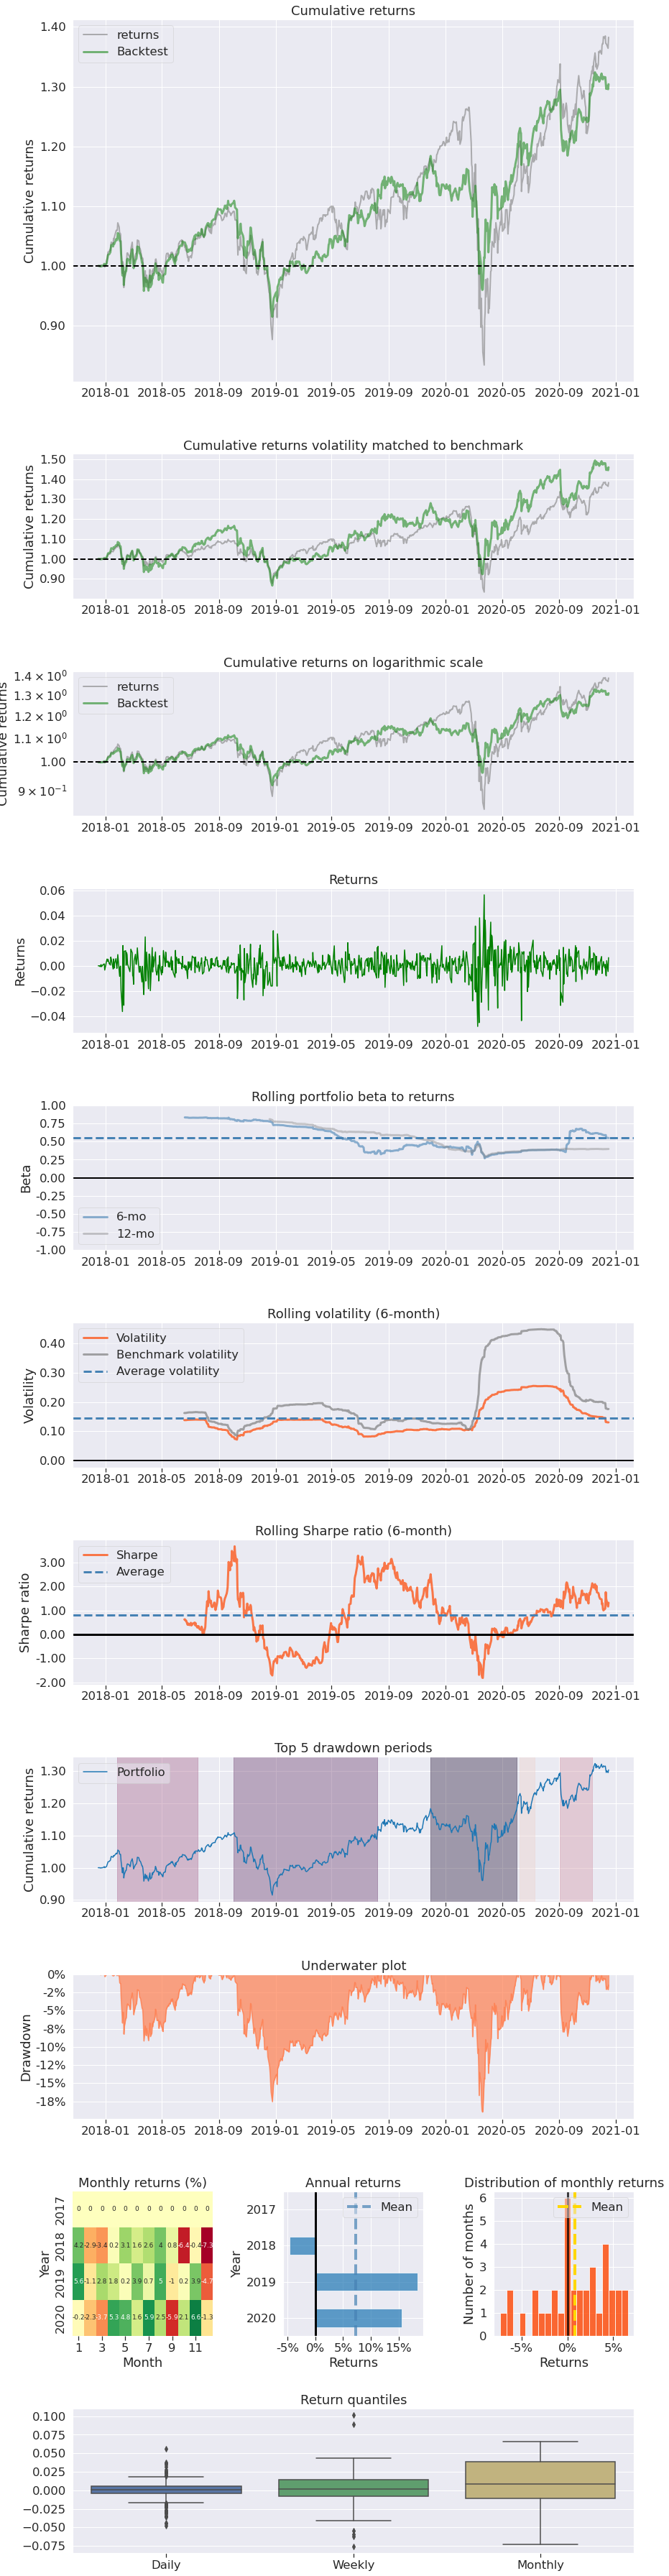

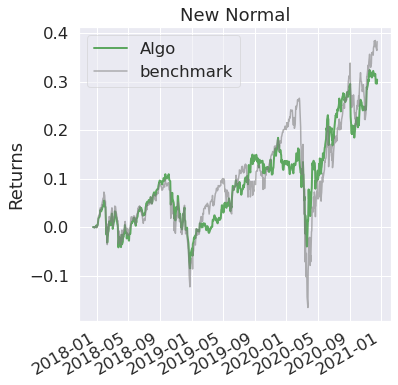

In [36]:
pf.create_full_tear_sheet(strategy_returns, benchmark_rets=benchmark_returns)

# Sharpe Ratio

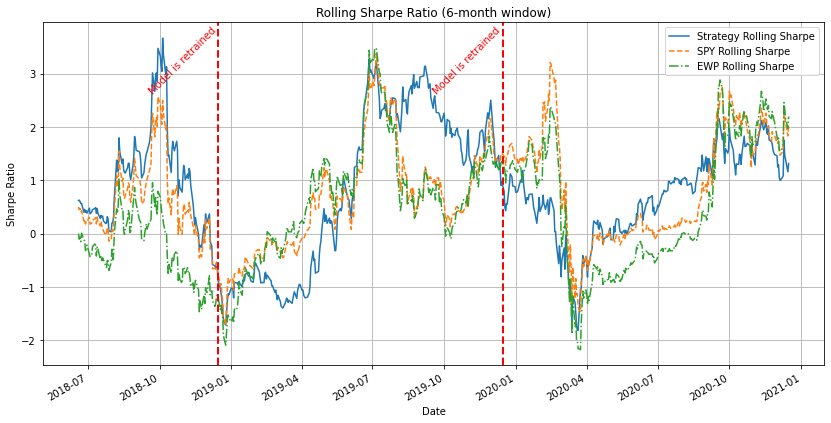

In [37]:
risk_free_rate = 0.0  # Adjust as necessary
window = 126  # 6 months rolling window for daily returns

# Calculate daily excess returns for both strategy and benchmark
excess_returns_strategy = strategy_returns - risk_free_rate
excess_returns_benchmark = benchmark_returns - risk_free_rate
excess_returns_eqp = eqp_returns - risk_free_rate

# Calculate rolling Sharpe ratios for each series
rolling_sharpe_strategy = (excess_returns_strategy.rolling(window=window).mean() / 
                           excess_returns_strategy.rolling(window=window).std()) * np.sqrt(252)

rolling_sharpe_benchmark = (excess_returns_benchmark.rolling(window=window).mean() / 
                            excess_returns_benchmark.rolling(window=window).std()) * np.sqrt(252)

rolling_sharpe_eqp = (excess_returns_eqp.rolling(window=window).mean() / 
                      excess_returns_eqp.rolling(window=window).std()) * np.sqrt(252)

# Plotting the rolling Sharpe ratios
plt.figure(figsize=(14, 7))
rolling_sharpe_strategy.plot(label='Strategy Rolling Sharpe', legend=True)
rolling_sharpe_benchmark.plot(label='SPY Rolling Sharpe', legend=True, linestyle='--')
rolling_sharpe_eqp.plot(label='EWP Rolling Sharpe', legend=True, linestyle='-.')
plt.title('Rolling Sharpe Ratio (6-month window)')
plt.ylabel('Sharpe Ratio')
plt.xlabel('Date')
plt.grid(True)

# Assuming the add_retrain_dates function plots vertical lines or markers at specific dates
add_retrain_dates(plt)  # Uncomment and define this function based on your needs

plt.show()

# Cumultive Returns 

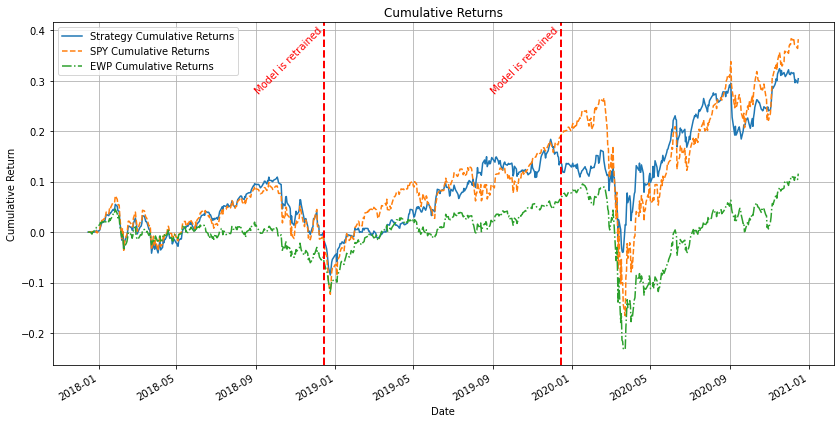

In [38]:
cumulative_returns_strategy = (1 + strategy_returns).cumprod() - 1
cumulative_returns_benchmark = (1 + benchmark_returns).cumprod() - 1
cumulative_returns_eqp = (1 + eqp_returns).cumprod() - 1

# Plot the cumulative returns including eqp_returns
plt.figure(figsize=(14, 7))
cumulative_returns_strategy.plot(label='Strategy Cumulative Returns', legend=True)
cumulative_returns_benchmark.plot(label='SPY Cumulative Returns', legend=True, linestyle='--')
cumulative_returns_eqp.plot(label='EWP Cumulative Returns', legend=True, linestyle='-.')



add_retrain_dates(plt)

plt.title('Cumulative Returns')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.show()

# Rolling volatility

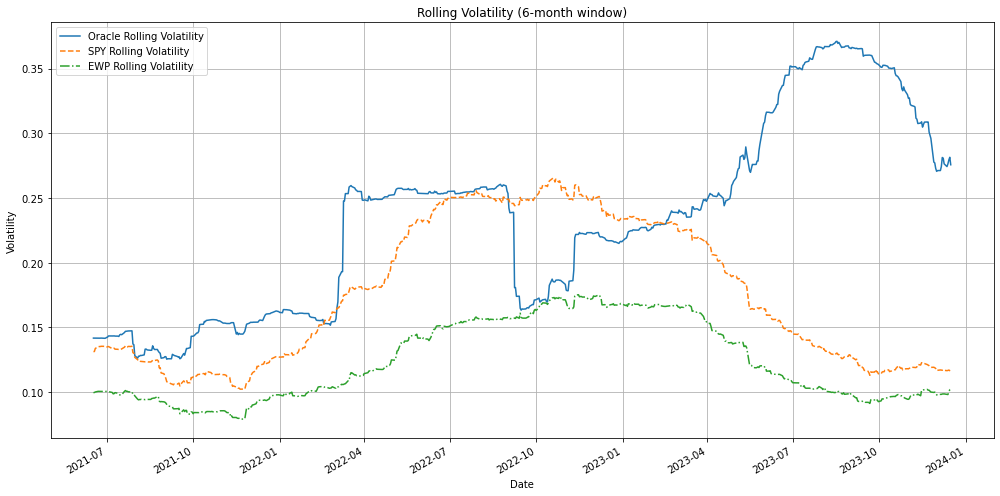

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

# Assuming 'strategy_returns' and 'benchmark_returns' are Pandas Series
# of your strategy's and benchmark's daily returns, respectively
window = 126  # Define the rolling window (e.g., 126 trading days for a 6-month window)

# Calculate rolling volatility for both strategy and benchmark
rolling_volatility_strategy = strategy_returns.rolling(window=window).std() * np.sqrt(252)  # Annualize the volatility
rolling_volatility_benchmark = benchmark_returns.rolling(window=window).std() * np.sqrt(252)  # Annualize the volatility
rolling_volatility_eqp = eqp_returns.rolling(window=window).std() * np.sqrt(252)  # Annualize the volatility

# Plot the rolling volatilities including eqp_returns
plt.figure(figsize=(14, 7))
rolling_volatility_strategy.plot(label='Oracle Rolling Volatility', legend=True)
rolling_volatility_benchmark.plot(label='SPY Rolling Volatility', legend=True, linestyle='--')
rolling_volatility_eqp.plot(label='EWP Rolling Volatility', legend=True, linestyle='-.')


plt.title('Rolling Volatility (6-month window)')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.tight_layout()  # Adjust layout to make room for the legend and annotations
#add_retrain_dates(plt)
plt.show()


# Rolling beta

C:\Users\seidm\AppData\Local\Temp\tmpt3ydnxcn\ipykernel_8044\3946155852.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  rolling_beta = pd.Series(index=strategy_returns.index)


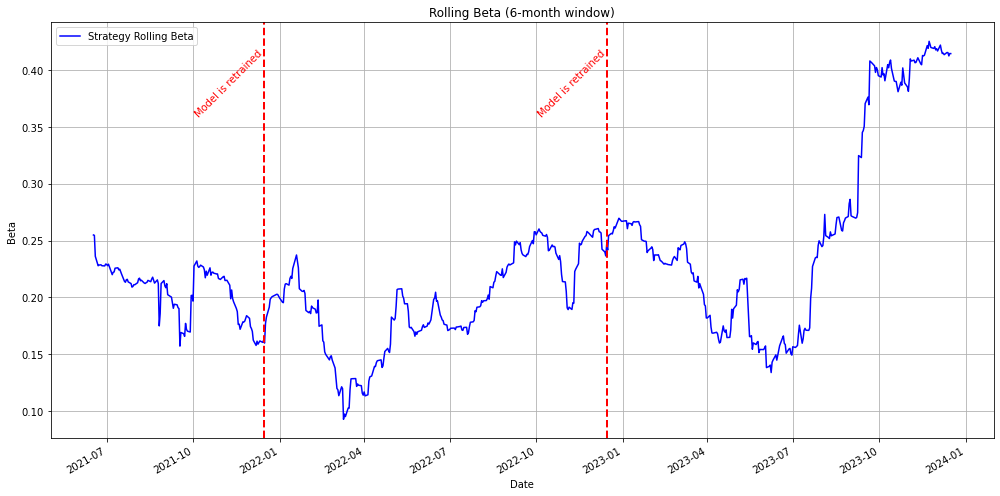

In [32]:
window = 126  # 6 months rolling window

# Prepare the benchmark returns with an intercept for OLS regression
benchmark_returns_with_const = sm.add_constant(benchmark_returns)

# Initialize an empty DataFrame to store the rolling beta
rolling_beta = pd.Series(index=strategy_returns.index)

# Perform the rolling regression
for end in range(window, len(strategy_returns) + 1):
    start = end - window
    y = strategy_returns[start:end]
    X = benchmark_returns_with_const[start:end]
    model = sm.OLS(y, X).fit()
    rolling_beta[end-1] = model.params[1]  # params[0] is the intercept, params[1] is the beta

# Plot the rolling beta
plt.figure(figsize=(14, 7))
rolling_beta.plot(label='Strategy Rolling Beta', color='blue')
plt.title('Rolling Beta (6-month window)')
plt.ylabel('Beta')
plt.xlabel('Date')
plt.grid(True)

# Add vertical red lines for model retraining dates
retrain_dates = [date(2021, 12, 15), date(2022, 12, 15)]
for retrain_date in retrain_dates:
    plt.axvline(x=retrain_date, color='red', linestyle='--', lw=2)

# Dynamically adjust the vertical position for annotations to avoid intersection
adjustment_factor = plt.ylim()[1] * 0.95  # Adjust this factor as needed

# Annotate the red lines, adjusting the y position
for retrain_date in retrain_dates:
    plt.text(retrain_date, adjustment_factor, 'Model is retrained', color='red', ha='right', va='top', rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

C:\Users\seidm\AppData\Local\Temp\tmpt3ydnxcn\ipykernel_8044\2104972555.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  rolling_beta = pd.Series(index=strategy_returns.index)


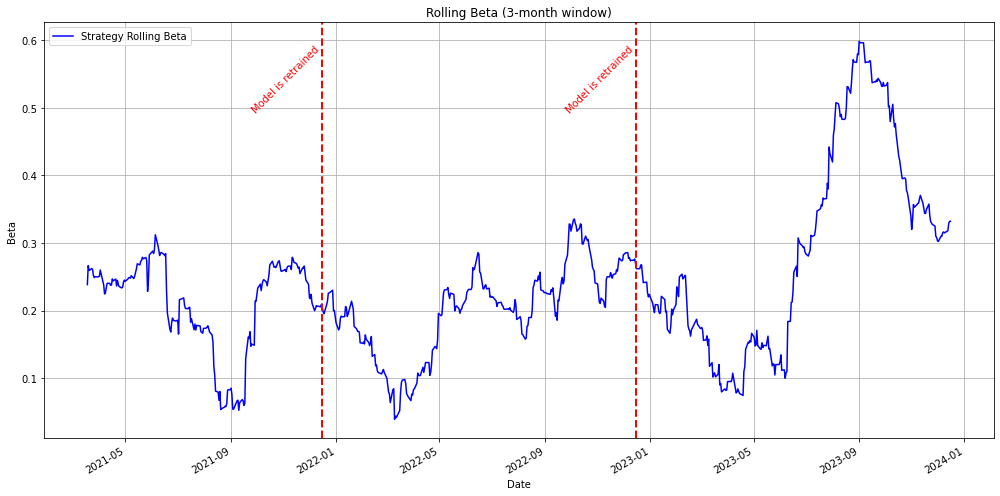

In [33]:
window = 63  # 3 months rolling window

# Prepare the benchmark returns with an intercept for OLS regression
benchmark_returns_with_const = sm.add_constant(benchmark_returns)

# Initialize an empty DataFrame to store the rolling beta
rolling_beta = pd.Series(index=strategy_returns.index)

# Perform the rolling regression
for end in range(window, len(strategy_returns) + 1):
    start = end - window
    y = strategy_returns[start:end]
    X = benchmark_returns_with_const[start:end]
    model = sm.OLS(y, X).fit()
    rolling_beta[end-1] = model.params[1]  # params[0] is the intercept, params[1] is the beta

# Plot the rolling beta
plt.figure(figsize=(14, 7))
rolling_beta.plot(label='Strategy Rolling Beta', color='blue')
plt.title('Rolling Beta (3-month window)')
plt.ylabel('Beta')
plt.xlabel('Date')
plt.grid(True)

# Add vertical red lines for model retraining dates
retrain_dates = [date(2021, 12, 15), date(2022, 12, 15)]
for retrain_date in retrain_dates:
    plt.axvline(x=retrain_date, color='red', linestyle='--', lw=2)

# Dynamically adjust the vertical position for annotations to avoid intersection
adjustment_factor = plt.ylim()[1] * 0.95  # Adjust this factor as needed

# Annotate the red lines, adjusting the y position
for retrain_date in retrain_dates:
    plt.text(retrain_date, adjustment_factor, 'Model is retrained', color='red', ha='right', va='top', rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

# Distance between porfolio weights

In [12]:
def convert_to_list(string):
    # Remove leading and trailing brackets if they exist
    if string.startswith('[') and string.endswith(']'):
        string = string[1:-1]
    
    # Remove extra spaces and replace spaces with commas
    string = ', '.join(string.split())
    
    # Encapsulate in brackets to form a proper list string
    corrected_string = f'[{string}]'
    
    # Convert to a list using ast.literal_eval
    return ast.literal_eval(corrected_string)

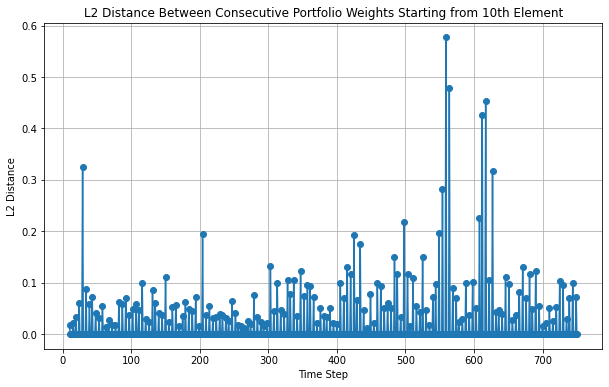

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example 'perf' DataFrame setup for demonstration; replace with your actual data
# perf = pd.DataFrame({
#     'weights': [
#         np.array([0.1, 0.9]),
#         np.array([0.2, 0.8]),
#         np.array([0.25, 0.75]),
#         # Your actual weight arrays
#     ]
# })

# Function to calculate L2 distance between two arrays
def calculate_l2_distance(arr1, arr2):
    return np.sqrt(np.sum((arr1 - arr2) ** 2))

# Start from the 10th element (index 9 since indexing starts at 0)
start_index = 9

# Calculate L2 distances starting from the 10th element
# l2_distances = np.array([
#     calculate_l2_distance(
#     np.array(ast.literal_eval(
#         convert_to_list(perf['weights'][i+4])
#     )), 
#     np.array(ast.literal_eval(
#         convert_to_list(perf['weights'][i+5])
#     ))
# )
#     for i in range(start_index, len(perf['weights']) - 1)
# ])


l2_distances = np.array([
    calculate_l2_distance(
    np.array(
        convert_to_list(perf['weights'][i])
    ), 
    np.array(
        convert_to_list(perf['weights'][i+1])
    )
)
    for i in range(start_index + 4, len(perf['weights']) - 1)
])


#l2_distances = l2_distances[l2_distances != 0]

# Plotting the L2 distances
plt.figure(figsize=(10, 6))
plt.plot(range(start_index + 1, start_index + len(l2_distances) + 1), l2_distances, marker='o', linestyle='-')
plt.title('L2 Distance Between Consecutive Portfolio Weights Starting from 10th Element')
plt.xlabel('Time Step')
plt.ylabel('L2 Distance')
plt.grid(True)
plt.show()


In [202]:
l2_distances.mean()

0.01647591194106324

In [82]:
perf['weights'][6]

'[0, 1, 0, 0, 0]'

In [17]:
def compute_average_weight(perf):
    weights_array = np.array([ast.literal_eval(weights) for weights in perf['weights'][5:]])

    # Calculate the average weight per column
    average_weights_per_column = np.mean(weights_array, axis=0)

    return average_weights_per_column

In [18]:
for p in [perf, benchmark, eqp_perf]:
    print(compute_average_weight(p))

[-0.04267693  0.33175712  0.0315716   0.55078601  0.12856216]
[0. 1. 0. 0. 0.]
[0.2 0.2 0.2 0.2 0.2]


In [44]:
sum(compute_average_weight(perf))

0.9999999922071304

# 